Finish training and validate on test data (print confusion matrix and report)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import tqdm

In [2]:
import torch
import torchvision
from torchvision import transforms
from torchsummary import summary
import keras
from torch.utils.data import DataLoader,Dataset
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import load

In [3]:
import torch.nn as nn
import torch.nn.functional as F  # Functional

In [4]:
#dataset is available https://drive.google.com/drive/folders/1WJemKpDspMnvEU_4oyxkxAxgvVihuKr5?usp=sharing
#you can

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path = '/content/drive/MyDrive/'

In [6]:
import os

In [7]:
directory = '/content/drive/MyDrive/NA_Fish_Dataset'
clases = os.listdir(directory)

In [8]:
clases

['Red Mullet',
 'Sea Bass',
 'Striped Red Mullet',
 'Shrimp',
 'Trout',
 'Black Sea Sprat',
 'Gilt Head Bream',
 'Horse Mackerel',
 'Red Sea Bream']

In [9]:
clases = clases[:3]

In [10]:
clases

['Red Mullet', 'Sea Bass', 'Striped Red Mullet']

In [11]:
directory = '/content/drive/MyDrive/NA_Fish_Dataset'
train_files = []
target_files = []
for fish_type in clases:
    for file in os.listdir(os.path.join(directory, fish_type)):
        train_files.append(os.path.join(directory, fish_type, file))
        target_files.append(fish_type)

In [12]:
df = pd.DataFrame({'img' : train_files, 'target' : target_files})
df.head()

,img,target
0,/content/drive/MyDrive/NA_Fish_Dataset/Red Mul...,Red Mullet
1,/content/drive/MyDrive/NA_Fish_Dataset/Red Mul...,Red Mullet
2,/content/drive/MyDrive/NA_Fish_Dataset/Red Mul...,Red Mullet
3,/content/drive/MyDrive/NA_Fish_Dataset/Red Mul...,Red Mullet
4,/content/drive/MyDrive/NA_Fish_Dataset/Red Mul...,Red Mullet


In [13]:
len(df)

150

In [14]:
img = []
for ind in tqdm.tqdm(range(len(df['img']))):
    origImage = cv2.imread(df['img'][ind])
    origImage = cv2.resize(origImage, (256, 256))
    img.append(origImage)
df['img'] = img

100%|██████████| 150/150 [03:40<00:00,  1.47s/it]


In [15]:
torch.cuda.is_available()

True

In [16]:
df.head()

,img,target
0,"[[[125, 101, 64], [125, 99, 73], [125, 103, 67...",Red Mullet
1,"[[[116, 95, 60], [119, 96, 67], [120, 95, 59],...",Red Mullet
2,"[[[133, 109, 54], [136, 115, 71], [134, 128, 8...",Red Mullet
3,"[[[132, 112, 65], [134, 123, 119], [137, 117, ...",Red Mullet
4,"[[[128, 104, 58], [125, 99, 65], [136, 117, 91...",Red Mullet


In [17]:
df['target'].unique()

array(['Red Mullet', 'Sea Bass', 'Striped Red Mullet'], dtype=object)

In [18]:
y = []
for i in range(len(df['target'])):
    for j in range(len(clases)):
        if df['target'][i] == clases[j]:
            y.append(j)

In [19]:
df.head()

,img,target
0,"[[[125, 101, 64], [125, 99, 73], [125, 103, 67...",Red Mullet
1,"[[[116, 95, 60], [119, 96, 67], [120, 95, 59],...",Red Mullet
2,"[[[133, 109, 54], [136, 115, 71], [134, 128, 8...",Red Mullet
3,"[[[132, 112, 65], [134, 123, 119], [137, 117, ...",Red Mullet
4,"[[[128, 104, 58], [125, 99, 65], [136, 117, 91...",Red Mullet


In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(img, y, test_size=0.2, random_state=10)

In [21]:
len(y_train)

120

In [22]:
len(y_test)

30

In [23]:
import torch
import torchvision
from torchvision import transforms
from torchsummary import summary
from torch.utils.data import DataLoader,Dataset
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
class MyDataset(Dataset):
    def __init__(self, data, targets,transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        if self.transform:
            x = Image.fromarray(self.data[index].astype(np.uint8))
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)
%matplotlib inline
transform = transforms.Compose([transforms.ToTensor()])
dataset = MyDataset(X_train,y_train, transform=transform)
trainloader = DataLoader(dataset, batch_size=4)

testset = MyDataset(X_test,y_test, transform=transform)
testloader = DataLoader(testset, batch_size=4)

In [24]:
class MyConvNet(nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super(MyConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels= 6, out_channels=16, kernel_size=5) # in_channels should match the out_channels of the prev layer
        self.fc1 = nn.Linear(16 * 61 * 61, 120)  # !!!
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3) # number of classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, 16 * 61 * 61)  # !!!
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [25]:
if torch.cuda.is_available():
  net = MyConvNet().cuda()
else:
  net = MyConvNet()

batch = []



batch = next(iter(trainloader))
print(batch[0].shape)

# net.forward(torch.FloatTensor(batch[0]))

torch.Size([4, 3, 256, 256])


In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:

loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
train_losses = []
test_losses = []
running_loss = 0
# итерируемся
for epoch in (range(10)):
    train_loss = []
    test_loss = []
    for i, batch in enumerate(trainloader):
        X_batch, y_batch = batch
        X_batch = X_batch.to(device=device, dtype=torch.float32)
        y_batch = y_batch.to(device = device, dtype = torch.long)
        optimizer.zero_grad()
        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        net.train(False)

    with torch.no_grad():
        for i, batch in enumerate(testloader):
            X_test_batch, y_pred_batch = batch
            X_test_batch = X_test_batch.to(device=device, dtype=torch.float32)
            y_pred_batch = y_pred_batch.to(device = device, dtype = torch.long)
            y_test_pred = net(X_test_batch)
            test_l = loss_fn(y_test_pred, y_pred_batch)
            test_loss.append(test_l.item())
    train_losses.append(np.mean(train_loss))
    test_losses.append(np.mean(test_loss))
    print('epoch ',epoch, ' train_loss ',np.mean(np.mean(train_loss)), ' test_loss ',np.mean(test_loss))


epoch  0  train_loss  1.1034903248151144  test_loss  1.0935674160718918
epoch  1  train_loss  1.0908870100975037  test_loss  1.086588367819786
epoch  2  train_loss  1.0646283626556396  test_loss  1.0471921861171722
epoch  3  train_loss  1.0114664296309153  test_loss  0.9672616049647331
epoch  4  train_loss  0.9125318268934886  test_loss  0.8501110523939133
epoch  5  train_loss  0.7622892657915751  test_loss  0.6798393689095974
epoch  6  train_loss  0.5809857159852981  test_loss  0.5305256880819798
epoch  7  train_loss  0.43878517548243207  test_loss  0.43633955158293247
epoch  8  train_loss  0.3398328547676404  test_loss  0.3700941763818264
epoch  9  train_loss  0.25823455303907394  test_loss  0.34124662075191736


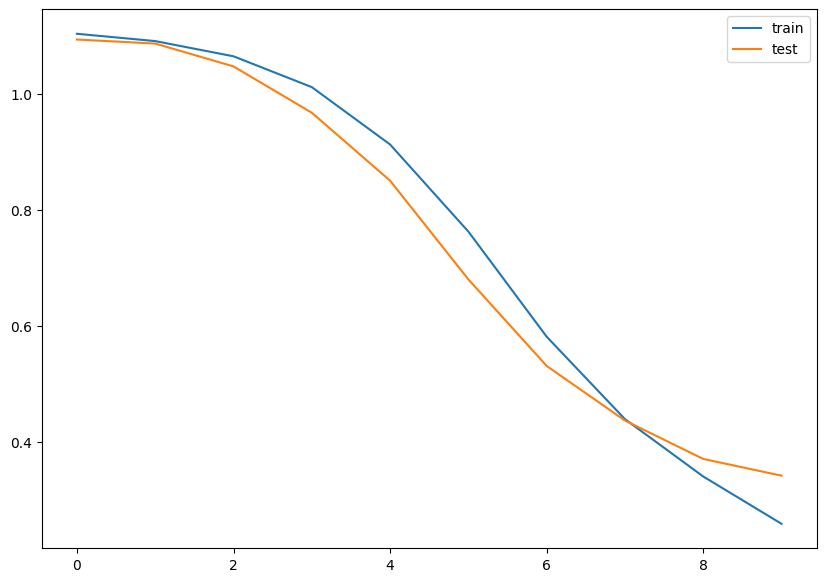

In [28]:
plt.figure(figsize=(10,7))
plt.plot(range(len(train_losses)), train_losses, label='train')
plt.plot(range(len(test_losses)), test_losses, label='test')
plt.legend()
plt.show()

In [29]:
#Test your model on X_test data and show confusion_matrix and classification_report

from sklearn.metrics import confusion_matrix, classification_report
import torch
import numpy as np

net.eval()  # Set the model to evaluation mode
y_true = []  # Ground truth labels
y_pred = []  # Predicted logits

with torch.no_grad():
    for i, batch in enumerate(testloader):
        X_test_batch, y_test_batch = batch
        X_test_batch = X_test_batch.to(device=device, dtype=torch.float32)

        # prediction
        y_test_pred = net(X_test_batch)

        y_true.extend(y_test_batch.cpu().numpy())
        y_pred.extend(y_test_pred.cpu().detach())

# Convert lists to NumPy arrays
test = np.array(y_true)

# Get the predicted class labels
pred = np.argmax(np.array([tensor.numpy() for tensor in y_pred]), axis=1)

In [30]:
y_pred[:5]

[tensor([-2.7795,  3.5348,  0.6204]),
 tensor([-0.2077, -0.7724,  3.1790]),
 tensor([ 4.0041, -2.0577,  0.4553]),
 tensor([ 0.2031,  2.0480, -0.6659]),
 tensor([ 2.4620, -1.1610,  1.0529])]

In [38]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test, pred))
from sklearn.metrics import classification_report
print(classification_report(test, pred, target_names=clases))

[[ 9  1  0]
 [ 0 13  0]
 [ 3  0  4]]
                    precision    recall  f1-score   support

        Red Mullet       0.75      0.90      0.82        10
          Sea Bass       0.93      1.00      0.96        13
Striped Red Mullet       1.00      0.57      0.73         7

          accuracy                           0.87        30
         macro avg       0.89      0.82      0.84        30
      weighted avg       0.89      0.87      0.86        30



Class probabilities
Class Red Mullet: 0.032115
Class Sea Bass: 0.018258
Class Striped Red Mullet: 0.949627


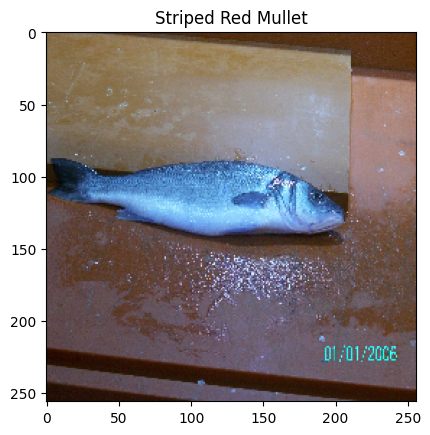

Predicted Class: Striped Red Mullet


In [48]:
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

image_index = 1  # Desired image
# Image preprocessing
img = Image.fromarray(X_test[image_index])
img = img.resize((256, 256))
img_tensor = transform(img).unsqueeze(0)  # Add batch dimension

# Making prediction
net.eval()
with torch.no_grad():
    img_tensor = img_tensor.to(device)
    prediction = net(img_tensor)

# Convert prediction to class label
probabilities = F.softmax(prediction, dim=1)
predicted_class = torch.argmax(prediction).item()

print("Class probabilities")
for i, prob in enumerate(probabilities[0]):
  print(f"Class {clases[i]}: {prob.item():4f}")

# Display image
plt.imshow(Image.fromarray(image_path))  # Convert numpy array to PIL Image
plt.title(clases[y_test[image_index]])
plt.show()

print(f"Predicted Class: {clases[predicted_class]}")
